In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import pgeocode, geopy
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns

### 0. Load covid cases dataset

In [2]:
%%time 
us_state_to_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT",
    "Delaware": "DE", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI",
    "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM",
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND",
    "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA",
    "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD",
    "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT",
    "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI",
    "Wyoming": "WY", "District of Columbia": "DC", 
    
    "American Samoa": "AS",
    "Guam": "GU", "Northern Mariana Islands": "MP", "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM", "U.S. Virgin Islands": "VI"
}

CPU times: total: 0 ns
Wall time: 0 ns


#### Data from New York Times github repository: https://github.com/nytimes/covid-19-data
- `cases`: The number of new cases of Covid-19 reported that day, including both confirmed and probable.
- `cases_avg`: The average number of new cases reported over the most recent seven days of data.
- `cases_avg_per_100k`: The cases_avg per 100,000 people.
- `deaths`: The total number of new deaths from Covid-19 reported that day, including both confirmed and probable.
- `deaths_avg`: The daily average number of new deaths reported over the most recent period. County-level deaths are averaged over 30 days. State, territory and national deaths are averaged over 7 days.
- `deaths_avg_per_100k`: The deaths_avg per 100,000 people.

In [7]:
# County covid cases
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-counties-2020.csv'
df2020 = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-counties-2021.csv'
df2021 = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-counties-2022.csv'
df2022 = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-counties-2023.csv'
df2023 = pd.read_csv(url)

covid_county = pd.concat([df2020, df2021, df2022, df2023])
covid_county['year'] = covid_county['date'].str[:4].astype('int64')
covid_county['month'] = covid_county['date'].str[5:7].astype('int64')
covid_county['day'] = covid_county['date'].str[8:10].astype('int64')

covid_county['state_abbr'] = covid_county.state.apply(lambda x: us_state_to_abbrev[x] if x in us_state_to_abbrev.keys() else x)
covid_county['state_county'] = covid_county.progress_apply(lambda x: (x.state_abbr, x.county), axis = 1)

covid_county.head()

ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [ ]:
# State covid cases
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-states.csv'
covid_state = pd.read_csv(url)
covid_state['year'] = covid_state['date'].str[:4].astype('int64')
covid_state['month'] = covid_state['date'].str[5:7].astype('int64')
covid_state['day'] = covid_state['date'].str[8:10].astype('int64')
covid_state['state_abbr'] = covid_state.state.progress_apply(lambda x: us_state_to_abbrev[x] if x in us_state_to_abbrev.keys() else x)
covid_state.head()

### I. Load data and data manipulation
- Deal with datetime variables, 
- Check records quality & select good quality subrecords, 
- Fill missing location info

    - Data from Amine, combined discontinued records and split records that last to the other day(s) into multi-records
    - Note: the records only last till 2022/9/30 per Amine's processing that some users might actually does not have 2022 records available

#### 1) Load data

In [2]:
records = pd.read_parquet('Data/data_qianhua.parquet.gzip', engine = 'pyarrow')
print('There are {} records corresponding to {} full-time workers from Embee data.'.format(len(records), records.panelist_id.nunique()))
print('Selected full-time workers have records spanning from 2020 to 2022. (i.e., have their earlist record as late as 12/31/20 and their latest record as early as 1/1/22)')

FileNotFoundError: [Errno 2] No such file or directory: 'Data/data_qianhua.parquet.gzip'

In [ ]:
records.head()

#### 2) Convert and extract datetime info

In [ ]:
# Extract year, week, weekday information for modeling purpose
def deal_with_time(df):
    
    df_ = df.copy()
    df_['date'] = pd.to_datetime(df_['date'])
    
    df_['week'] = df_['date'].dt.isocalendar().week
    df_['weekday'] = df_['date'].dt.weekday # 0-6, Mon.-Sun.
    
    df_['year'] = df_['date'].dt.year
    df_['month'] = df_['date'].dt.month
    df_['day'] = df_['date'].dt.day

    df_['arrival_local'] = pd.to_datetime(df_['arrival_local'])
    df_['departure_local'] = pd.to_datetime(df_['departure_local'])
    df_['duration_s_compute'] = (df_['departure_local'] - df_['arrival_local']).dt.total_seconds()
    
    return df_

In [ ]:
records = deal_with_time(records)
records.groupby('panelist_id')['year'].agg(['min', 'max']).head()

#### 3) Check records quality

In [4]:
def record_quality(user_records):
    
    days_w_rec = user_records.date.nunique()
    total_span = (user_records.date.max() - user_records.date.min()).days + 1
    per_days_w_rec = days_w_rec / total_span
    min_date = min(user_records.date)
    max_date = max(user_records.date)
    
    
    max_consecutive_missing = pd.Series(user_records.date.unique()).diff().dt.days.iloc[1:].max() - 1
    
    
    return days_w_rec, total_span, per_days_w_rec, min_date, max_date, max_consecutive_missing

In [5]:
colNames = ['days_w_rec', 'total_span', 'per_days_w_rec', 'min_date', 'max_date', 'max_consecutive_missing']
x = records.groupby('panelist_id').progress_apply(record_quality)
quality = pd.DataFrame(x.tolist(), index = x.index, columns = colNames).rename_axis(x.index.name)

NameError: name 'records' is not defined

In [6]:
quality[(quality.min_date < '2020-03-01') & (quality.max_date > '2022-01-01')]

NameError: name 'quality' is not defined

In [13]:
quality[(quality.min_date < '2020-03-01') & (quality.max_date > '2022-01-01') & (quality.max_consecutive_missing <= 7) & (quality.per_days_w_rec >= 0.9)]

,days_w_rec,total_span,per_days_w_rec,min_date,max_date,max_consecutive_missing
panelist_id,,,,,,
EMBUSA-1033561,939,1000,0.939000,2020-01-05,2022-09-30,2.0
EMBUSA-1175033,681,701,0.971469,2020-02-25,2022-01-25,4.0
EMBUSA-1182541,944,990,0.953535,2019-12-31,2022-09-15,4.0
EMBUSA-1222267,839,911,0.920966,2019-12-30,2022-06-27,4.0
EMBUSA-1277336,835,861,0.969803,2019-12-30,2022-05-08,4.0
...,...,...,...,...,...,...
EMBUSA-2326944,941,946,0.994715,2020-02-25,2022-09-27,2.0
EMBUSA-2328203,942,947,0.994720,2020-02-27,2022-09-30,2.0
EMBUSA-2329989,853,892,0.956278,2020-02-29,2022-08-08,4.0


Text(0.5, 0, 'max_consecutive_missing')

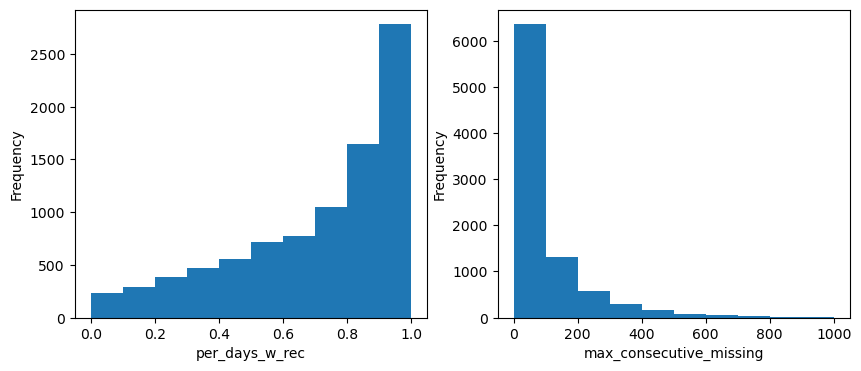

In [44]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
ax = quality['per_days_w_rec'].plot.hist(bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_xlabel('per_days_w_rec')
plt.subplot(1,2,2)
ax = quality['max_consecutive_missing'].plot.hist(bins = [0,100,200,300,400,500,600,700,800,900,1000])
ax.set_xlabel('max_consecutive_missing')

In [16]:
good_qual_user = quality[(quality.min_date < '2020-03-01') & (quality.max_date > '2022-01-01') & (quality.max_consecutive_missing <= 7) & (quality.per_days_w_rec >= 0.9)].index
print('If we only keep users with missing records less than 10% of the total span and consecutive missing days less than a week (7 days), {} ({}%) out of {} users are kept.'.format(len(good_qual_user), round(len(good_qual_user)/len(quality)*100), len(quality.index)))

If we only keep users with missing records less than 10% of the total span and consecutive missing days less than a week (7 days), 573 (6%) out of 8901 users are kept.


In [17]:
records = records.loc[records.panelist_id.isin(good_qual_user)]
print('A total of {} full-time workers with a total of {} records are kept.'.format(records.panelist_id.nunique(), len(records)))

A total of 573 full-time workers with a total of 2085072 records are kept.


#### 4) Deal with records missing location information (city + state + zip, county)
#### Get city, state, zip info

In [18]:
sum(records[records.city.isna()].index == records[records.state.isna()].index)
sum(records[records.state.isna()].index == records[records.zip.isna()].index)
print('A total of {} records missed location information, with city, state, zipcode, all three columns being None.'.format(len(records[records.city.isna()])))

A total of 368 records missed location information, with city, state, zipcode, all three columns being None.


In [19]:
subrecords = pd.read_csv('Data/fillInfo.csv').set_index('Unnamed: 0')
subrecords.replace({'state': us_state_to_abbrev}, inplace = True)
records.loc[records.city.isna(), ['city', 'state', 'zip']] = subrecords.loc[records[records.city.isna()].index, ['city', 'state', 'zip']]
print('After filling the geo information, {} records miss city information, {} records miss state information, {} records miss zipcode information.'.format(len(records[records.city.isna()]), len(records[records.state.isna()]), len(records[records.zip.isna()])))

After filling the geo information, 356 records miss city information, 12 records miss state information, 315 records miss zipcode information.


#### Get county infomation

In [20]:
# %%time 

# geolocator = geopy.geocoders.Nominatim(user_agent = 'norah')
# def get_country(row):
#     try:
#         geoinfo = geolocator.reverse(str(row.latitude)+", "+str(row.longitude))
#         return geoinfo.raw['address'].get('country', None)
    
#     except:
#         return None

# country = records[(records.county.isna()) & (~records.zip.isna())].progress_apply(get_country, axis = 1)
# print('{} records have zipcode records available but cannot get county information. These records are in {}'.format(len(country), country.unique()))

In [21]:
nomi = pgeocode.Nominatim('us')
records['county'] = nomi.query_postal_code(records.zip.str[:5].values).county_name.values
nomi = pgeocode.Nominatim('ca')
records.loc[records.county.isna(),'county'] = nomi.query_postal_code(records.loc[records.county.isna()].zip.str[:5].values).county_name.values
nomi = pgeocode.Nominatim('mx')
records.loc[records.county.isna(), 'county'] = nomi.query_postal_code(records.loc[records.county.isna()].zip.str[:5].values).county_name.values

In [22]:
print('We tried to infer county by zipcode, but cannot get the information for {} records.'.format(len(records[records.county.isna()])))
print('Among which, {} records are due to missing zipcode info, {} records have zipcode info but cannot locate the corresponding county'.format(len(records[records.zip.isna()]), len(records[records.county.isna()]) - len(records[records.zip.isna()])))

We tried to infer county by zipcode, but cannot get the information for 455 records.
Among which, 315 records are due to missing zipcode info, 140 records have zipcode info but cannot locate the corresponding county


In [23]:
def get_county(row):
    
    geolocator = geopy.geocoders.Nominatim(user_agent = 'norah')
    
    try:   
        
        geoinfo = geolocator.reverse(str(row.latitude)+", "+str(row.longitude))
        county = geoinfo.raw['address'].get('county', None)
        return county
    
    except:   
        return None


In [24]:
records.loc[records.county.isna(), 'county'] = records.loc[records.county.isna()].progress_apply(get_county, axis = 1)

100%|████████████████████████████████████████████████████████████████████████████████| 455/455 [03:48<00:00,  1.99it/s]


In [25]:
print('After final filling, only {} records remain without county information.'.format(len(records[records.county.isna()])))

After final filling, only 67 records remain without county information.


In [26]:
# Deal with inconsistency
records['county'].replace(np.nan, '', inplace = True)
records['county'] = records['county'].apply(lambda x: x.replace('(city)', 'city') if '(city)' in x else x)
records['county'] = records['county'].apply(lambda x: x.replace('City city', 'City') if 'City city' in x else x)
records.loc[(records.state == 'VA') & (records.county == 'Suffolk'), 'county'] = 'Suffolk city'
error_dict = {
              ' Parish': '',
              'Saint': 'St.',
              'City of ': '',
              'City and County of ': '',
              'Bronx': 'New York City'}
records['county'] = records['county'].replace(error_dict, regex = True)

In [28]:
records['state_county'] = records.progress_apply(lambda x: (x.state, x.county), axis = 1)
cantLocate = records[~(records.state_county.isin(covid_county.state_county.unique()))]['state_county'].unique()
print('{} different counties are in the records, among which, {} ({:.1%}) county can not be located in covid dataframe.'.format(records.state_county.nunique(), len(cantLocate), len(cantLocate)/records.state_county.nunique()))

100%|█████████████████████████████████████████████████████████████████████| 2085072/2085072 [00:46<00:00, 44920.70it/s]


2412 different counties are in the records, among which, 151 (6.3%) county can not be located in covid dataframe.


### II. Extract Home State/County information


### II-1 Information consistency check

In [28]:
records.columns

Index(['panelist_id', 'date', 'latitude', 'longitude', 'city', 'state', 'zip',
       'prior_location_name', 'prior_brand', 'distance_traveled_m',
       'travel_time_s', 'location_name', 'category', 'brand', 'is_home',
       'is_work', 'is_open', 'dist_from_work', 'dist_from_home',
       'arrival_local', 'duration', 'duration_s_compute', 'departure_local',
       'year', 'week', 'weekday', 'month', 'day', 'county', 'state_county'],
      dtype='object')

1) 'location_name' is consistent with 'dist_from_work', 'dist_from_home' information. 
    - 'location_name' = 'home' <-> 'dist_from_home' = 0
    - 'location_name' = 'work' <-> 'dist_from_work' = 0 

2) 'location_name' and 'is_home/work' information not consistent
    - 'is_home' = 1 -> 'location_name' = 'home'; but 'location_name' = 'home', 'is_home' can be NaN (977015)
        - Suppose due to Amine's data processing (merge/split record) - Evidence 'duration' = NaN
    - 'is_work' = 1, 'location_name' can be 'work' (2132534) or 'home' (259285); 'location_name' = 'work', 'is_work' can be NaN (269506)
        - Same here. 'duration' = NaN

3) Questionable part: 'location_name' = 'home', but both 'is_home', 'is_work' is 1
    - When 'is_work' = 1 & 'location_name' = 'home', 'dist_from_work' is not exactly 0 but ~0-400 (see the distribution below)
    - When 'is_work' = 1 & 'location_name' = 'work', 'dist_from_home' ranges from 300 to 3 * 10^6

4) Final decision: Treat 'location_name' as a more reliable information than 'is_work'/'is_home'

5) Other possible solutions: Cluster lat, lon information and assign label to each cluster.

In [876]:
info = ['arrival_local', 'departure_local', 'latitude', 'longitude', 'dist_from_home', 'dist_from_work']

In [877]:
def dist_check(user_records):
    
    total = len(user_records)
    
    isWlocH_fromW_mean = user_records[(user_records.is_work == 1) & (user_records.location_name == 'home')]['dist_from_work'].mean()
    isWlocH_fromW_std = user_records[(user_records.is_work == 1) & (user_records.location_name == 'home')]['dist_from_work'].std()
    isWlocH_fromH_mean = user_records[(user_records.is_work == 1) & (user_records.location_name == 'home')]['dist_from_home'].mean()
    isWlocH_fromH_std = user_records[(user_records.is_work == 1) & (user_records.location_name == 'home')]['dist_from_home'].std()
    
    isWlocW_fromW_mean = user_records[(user_records.is_work == 1) & (user_records.location_name == 'work')]['dist_from_work'].mean()
    isWlocW_fromW_std = user_records[(user_records.is_work == 1) & (user_records.location_name == 'work')]['dist_from_work'].std()
    isWlocW_fromH_mean = user_records[(user_records.is_work == 1) & (user_records.location_name == 'work')]['dist_from_home'].mean()
    isWlocW_fromH_std = user_records[(user_records.is_work == 1) & (user_records.location_name == 'work')]['dist_from_home'].std()
    
    return total, isWlocH_fromW_mean, isWlocH_fromW_std, isWlocH_fromH_mean, isWlocH_fromH_std, isWlocW_fromW_mean, isWlocW_fromW_std, isWlocW_fromH_mean, isWlocW_fromH_std

In [878]:
colNames = ['total', 'isW_locH_fromW_mean', 'isW_locH_fromW_std', 'isW_locH_fromH_mean', 'isW_locH_fromH_std', 'isW_locW_fromW_mean', 'isW_locW_fromW_std', 'isW_locW_fromH_mean', 'isW_locW_fromH_std']
user_weirdRec = records[(records.is_work == 1) & (records.location_name == 'home')]['panelist_id'].unique()
x = records.loc[records.panelist_id.isin(user_weirdRec),:].groupby('panelist_id').apply(dist_check) 
dist = pd.DataFrame(x.tolist(), index = x.index, columns = colNames).rename_axis(x.index.name)

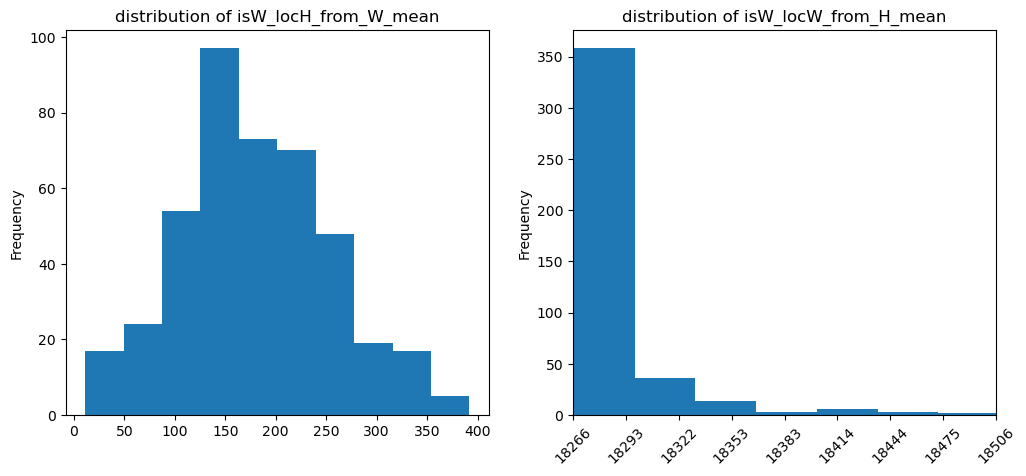

In [882]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))
dist.isW_locH_fromW_mean.plot.hist(ax = axs[0], title = 'distribution of isW_locH_from_W_mean')
dist.isW_locW_fromH_mean.plot.hist(ax = axs[1], title = 'distribution of isW_locW_from_H_mean', xlim = [0, 800000])
axs[1].set_xticklabels(ax.get_xticksla().astype(int), rotation = 45)
None

### II-2 Get home state/county

- 107 individuals have more than one home state
- 212 individuals have more than one home county

In [552]:
# How well is the approximation. Distribution of majority
def getHomeLoc(user_record):
    """
    Extract the state that appears most frequently (with the highest number of days) when location_name == 1 as home state for each individual
    and assume individuals will check the number of covid cases in their home state before making a decision of whether travel or not
    
    Return
    -----------------------------
    State name with the highest appearance, number of days this home state appear / number of days the individual has home records as the representativeness of this state info
    """
    state_freq = user_record[user_record.location_name == 'home'].groupby(['state'])['date'].agg(['nunique', 'min', 'max']).sort_values(by = 'nunique', ascending = False)
    most_freq_state, freq, homeState_span, num_home_state = state_freq.index[0], state_freq.iloc[0]['nunique'], state_freq.iloc[0][['min','max']].diff()[1].days, len(state_freq) 
    overlap = sum(user_record[user_record.location_name == 'home'].groupby(['date'])['state'].nunique() >= 2)
    
    state_county_freq = user_record[user_record.location_name == 'home'].groupby(['state', 'county'])['date'].agg(['nunique', 'min', 'max']).sort_values(by = 'nunique', ascending = False)
    most_freq_pair, pair_freq, homeCounty_span, num_pair = state_county_freq.index[0], state_county_freq.iloc[0]['nunique'], state_county_freq.iloc[0][['min', 'max']].diff()[1].days, len(state_county_freq)
    
    total_home_days = user_record[user_record.location_name == 'home']['date'].nunique()
    homeRec_span = (user_record[(user_record.location_name == 'home')]['date'].max() - user_record[(user_record.location_name == 'home')]['date'].min()).days
    totalRec_span = (user_record['date'].max() - user_record['date'].min()).days
    
    
    return most_freq_state, freq/total_home_days, homeState_span / homeRec_span, num_home_state, overlap, '{:.2%}'.format(overlap/total_home_days), most_freq_pair, pair_freq/total_home_days, homeCounty_span / homeRec_span, num_pair, total_home_days, homeRec_span, totalRec_span
    

In [553]:
x = records.groupby('panelist_id').progress_apply(getHomeLoc)
homeState = pd.DataFrame(x.tolist(), index = x.index, columns = ['home_state', 'repr_perDay_s', 'repr_perSpan_s', 'num_home_state', 'num_days_multi_home_state', 'per_days_multi_home_state', 'home_state_county', 'repr_perDay_sc', 'repr_perSpan_sc', 'num_home_county', 'total_home_days', 'homeRec_span', 'totalRec_span'] ).rename_axis(x.index.name)

100%|███████████████████████████████████████████████████████████████████████████████████████| 573/573 [00:09<00:00, 58.58it/s]


#### Check the algorithm
- Some people have multi home state/county
    - 107 (18.7%) individuals have multiple home state
    - 212 (37%) individuals have multiple home county
- Two problems with these people
    - Some moved during the span
        - representative (use the home state with the max frequency is enough)
        - not representative (need to change their home state when they moved)
    - Some people appears at two home locations (in different states) within the same day
        - 11 individuals (1.9%) in total. MAX percentage of such days over total days with records is 1.6%
        - (won't have too much impact, can be ignored for now)

num_home_state    1   2   3  5  4  7
count           466  88  16  1  1  1
-----------------------------------------------------------
107 individuals have more than 1 home state
num_home_county   1    2   3   4   6   7   5   12
count            361  159  34  13   3   1   1   1
-----------------------------------------------------------
212 individuals have more than 1 home county


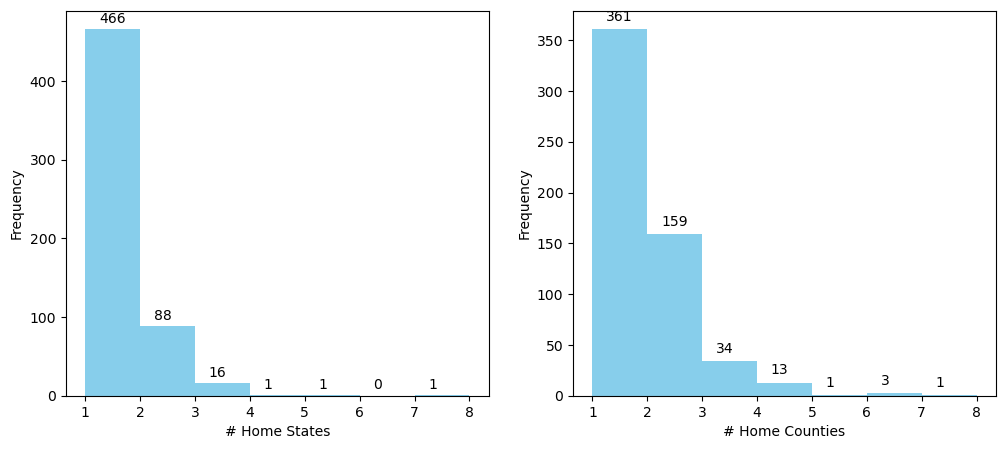

In [576]:
print(homeState.num_home_state.value_counts().to_frame().T)
print('-----------------------------------------------------------')
print('{} individuals have more than 1 home state'.format(sum(homeState.num_home_state.value_counts()[1:])))

print(homeState.num_home_county.value_counts().to_frame().T)
print('-----------------------------------------------------------')
print('{} individuals have more than 1 home county'.format(sum(homeState.num_home_county.value_counts()[1:])))

plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
chart = homeState.num_home_state.plot(bins = [1,2,3,4,5,6,7,8], kind = 'hist', ax = plt.gca(), color = ['skyblue'])
chart.set_xlabel('# Home States')
for p in plt.gca().patches:
    plt.gca().annotate(round(p.get_height()), (p.get_x() + 0.25, p.get_height() + 8))

plt.subplot(1,2,2)
chart = homeState.num_home_county.plot(bins = [1,2,3,4,5,6,7,8], kind = 'hist', ax = plt.gca(), color = ['skyblue'])
chart.set_xlabel('# Home Counties')
for p in plt.gca().patches:
    plt.gca().annotate(round(p.get_height()), (p.get_x() + 0.25, p.get_height() + 8))

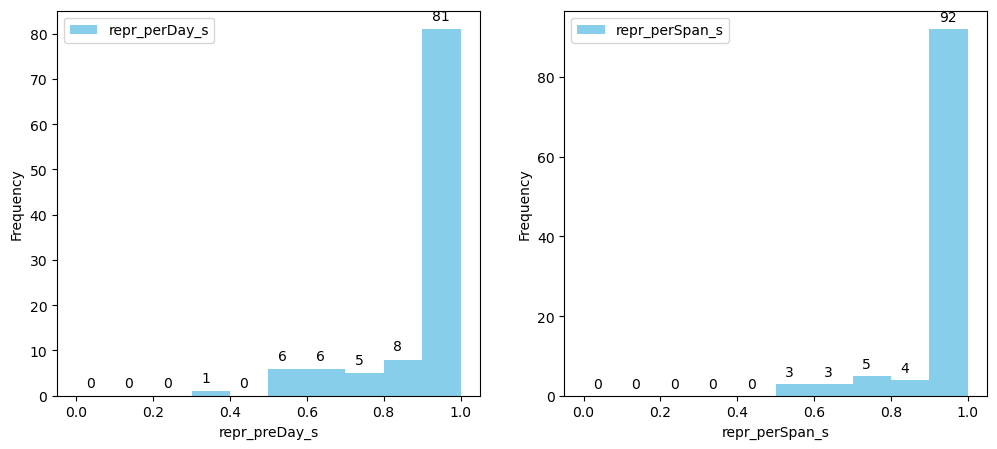

In [585]:
plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
chart = homeState[homeState.num_home_state >= 2][['repr_perDay_s']].plot(kind = 'hist', bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax = plt.gca(), color = ['skyblue'])
chart.set_xlabel('repr_preDay_s')
for p in plt.gca().patches:
    plt.gca().annotate(round(p.get_height()), (p.get_x() + 0.025, p.get_height() + 2))
    
plt.subplot(1,2,2)
chart = homeState[homeState.num_home_state >= 2][['repr_perSpan_s']].plot(kind = 'hist', bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ax = plt.gca(), color = ['skyblue'])
chart.set_xlabel('repr_perSpan_s')
for p in plt.gca().patches:
    plt.gca().annotate(round(p.get_height()), (p.get_x() + 0.025, p.get_height() + 2))

#### Move

In [566]:
def plot_home_status(records, user_id):
    
    rec = records[(records.panelist_id == 'EMBUSA-'+user_id) & (records.location_name == 'home')][['state', 'date']]
    dict_ = dict(zip(rec['state'].unique(), range(len(rec['state'].unique()))))
    rec['y'] = rec['state'].map(dict_)
    chart = sns.scatterplot(data = rec, x = 'date', y = 'y', hue = 'state')
    chart.set_xticklabels(chart.get_xticklabels(), rotation = 10)
    chart.set_yticks(range(len(rec['state'].unique())))
    chart.set_yticklabels(dict_.keys(), rotation = 90)
    chart.set_ylabel('')
    chart.set_xlabel('')
    chart.set_title(user_id)
    None

In [587]:
# rec = homeState.sort_values(by = 'repr_perSpan_s').head(50)

# import warnings
# warnings.filterwarnings("ignore")

# plt.figure(figsize = (20, 20))
# for i in range(25):
#     ax = plt.subplot(5, 5, i+1)
#     plot_home_status(records, rec.index[i][7:])
# plt.show()

# plt.figure(figsize = (20, 20))
# for i in range(25):
#     ax = plt.subplot(5, 5, i+1)
#     plot_home_status(records, rec.index[i+25][7:])
# plt.show()

#### Overlap

In [591]:
import geopy.distance
def dist_btw_home_loc(user_record):
    
    home_loc = user_record[user_record.location_name == 'home'].groupby('state')[['latitude', 'longitude']].mean()
    coords_1 = (home_loc.iloc[0]['latitude'], home_loc.iloc[0]['longitude'])
    coords_2 = (home_loc.iloc[1]['latitude'], home_loc.iloc[1]['longitude'])
    
    return geopy.distance.geodesic(coords_1, coords_2).km

records[records.panelist_id.isin(homeState[homeState.num_home_state >= 2].index)].groupby('panelist_id').progress_apply(dist_btw_home_loc).describe().to_frame().T

100%|██████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 261.39it/s]


,count,mean,std,min,25%,50%,75%,max
0,107.0,1349.193202,1309.13748,11.078551,428.224839,947.085741,1940.759716,7627.270828


In [588]:
homeState[homeState.num_days_multi_home_state >= 1].sort_values(by = 'num_days_multi_home_state', ascending = False)

,home_state,repr_perDay_s,repr_perSpan_s,num_home_state,num_days_multi_home_state,per_days_multi_home_state,home_state_county,repr_perDay_sc,repr_perSpan_sc,num_home_county,total_home_days,homeRec_span,totalRec_span
panelist_id,,,,,,,,,,,,,
EMBUSA-1033561,KS,0.577259,0.891675,2,11,1.60%,"(KS, Wyandotte)",0.577259,0.891675,2,686,997,999
EMBUSA-2235869,OH,0.960057,1.000000,2,4,0.57%,"(OH, Montgomery)",0.935806,1.000000,3,701,780,780
EMBUSA-2007814,IN,0.717472,0.777315,2,3,0.37%,"(IN, Lake)",0.717472,0.777315,2,807,961,964
EMBUSA-2328203,SC,0.995429,0.994715,2,3,0.34%,"(SC, Spartanburg)",0.990857,0.994715,3,875,946,946
EMBUSA-2246970,CA,0.935154,0.990160,2,2,0.34%,"(CA, San Diego)",0.935154,0.990160,2,586,813,813
EMBUSA-2329989,RI,0.987342,1.000000,2,2,0.25%,"(RI, Providence)",0.987342,1.000000,2,790,891,891
EMBUSA-1655695,OR,0.996829,1.000000,2,1,0.11%,"(OR, Washington)",0.996829,1.000000,2,946,1004,1004
EMBUSA-1663663,MO,0.890866,0.905812,2,1,0.12%,"(MO, Jackson)",0.890866,0.905812,2,843,998,1003
EMBUSA-1849153,DE,0.995019,1.000000,2,1,0.12%,"(DE, New Castle)",0.995019,1.000000,2,803,1000,1000


### III. Extract Trajectories
- Information needed includes
    - `Year`, `week`, `weekday`, `commute`, `commute_filled`, `missing`, `covid situations` in their home county & state that day. 

#### III-1 Extract trajectory & Deal with days with missing records

In [636]:
def fill_missing(df, N):
    """
    First N records, rand
    After the first N records, rand by looking into the distribution of previous N days (N can be 14, 21, 28), 
    which assumes the behavior of the individual does not change that much for only X (X = 2, 3, 4) weeks. 
    """
    df_ = df.copy()
    df_['commute_filled'] = df_['commute']
    missing_index = df_[df_.commute.isna()].index
    
    for index in missing_index:

        if index < N: 
            prob = dict(zip(range(7), [0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1])) # FIND SOME CITATIONS / EVIDENCE
        else:
            prob = df_.iloc[index - N:index].groupby('weekday')['commute_filled'].mean()
              
        df_.loc[index, 'commute_filled'] = np.random.binomial(1, prob[df_.loc[index].weekday])
 
    
    return df_

def extract_traj(user_record, N):
    """
    This function is used to extract trajectory for each user, each trajectory indicates the user went to the workplace or not 
    on a given weekday.
    """
    
    date_range = pd.DataFrame(pd.date_range(user_record.date.min(), user_record.date.max(), freq = 'd')).rename({0: 'date'}, axis = 1)
    date_range['week'] = date_range['date'].dt.isocalendar().week
    date_range['weekday'] = date_range['date'].dt.weekday # 0-6, Mon.-Sun.
    date_range['year'] = date_range['date'].dt.year
    date_range['month'] = date_range['date'].dt.month
    date_range['day'] = date_range['date'].dt.day
    
    work = pd.DataFrame(user_record.groupby(['year', 'month', 'day', 'week', 'weekday'])['location_name'].apply(set(['work']).issubset))
    work['commute'] = work['location_name'].astype(int) # 1 is commute while 0 is WFH
    work.reset_index(inplace=True)
    
    df = date_range.merge(work, left_on = ['year', 'month', 'day', 'week', 'weekday'], right_on = ['year', 'month', 'day', 'week', 'weekday'], how = 'left')
    
    df['missing'] = df['commute'].isna().astype(int)
    df = fill_missing(df, N)
    
    return np.array(df[['year','month','day','week','weekday','commute', 'commute_filled', 'missing']])

In [673]:
traj = records.groupby('panelist_id').progress_apply(lambda x: extract_traj(x, 21))
traj = pd.DataFrame(traj).rename({0: 'trajectory'}, axis = 1)
traj = traj.join(quality)
traj['first_missing'] = traj['trajectory'].apply(lambda x: x[:,7].argmax() if x[:,7].argmax() != 0 else np.nan)
traj['num_missing_7days'] = traj['trajectory'].apply(lambda x: x[:7,7].sum())
traj['num_missing_14days'] = traj['trajectory'].apply(lambda x: x[:14,7].sum())
traj['num_missing_21days'] = traj['trajectory'].apply(lambda x: x[:21,7].sum())
traj['num_missing_28days'] = traj['trajectory'].apply(lambda x: x[:28,7].sum())


100%|███████████████████████████████████████████████████████████████████████████████████████| 573/573 [00:36<00:00, 15.73it/s]


In [674]:
traj.head()

,trajectory,days_w_rec,total_span,per_days_w_rec,min_date,max_date,max_consecutive_missing,first_missing,num_missing_7days,num_missing_14days,num_missing_21days,num_missing_28days
panelist_id,,,,,,,,,,,,
EMBUSA-1033561,"[[2020, 1, 5, 1, 6, 0.0, 0.0, 0], [2020, 1, 6,...",939,1000,0.939000,2020-01-05,2022-09-30,2.0,2.0,2,5,7,9
EMBUSA-1175033,"[[2020, 2, 25, 9, 1, 0.0, 0.0, 0], [2020, 2, 2...",681,701,0.971469,2020-02-25,2022-01-25,4.0,33.0,0,0,0,0
EMBUSA-1182541,"[[2019, 12, 31, 1, 1, 0.0, 0.0, 0], [2020, 1, ...",944,990,0.953535,2019-12-31,2022-09-15,4.0,8.0,0,3,5,5
EMBUSA-1222267,"[[2019, 12, 30, 1, 0, 0.0, 0.0, 0], [2019, 12,...",839,911,0.920966,2019-12-30,2022-06-27,4.0,62.0,0,0,0,0
EMBUSA-1277336,"[[2019, 12, 30, 1, 0, 0.0, 0.0, 0], [2019, 12,...",835,861,0.969803,2019-12-30,2022-05-08,4.0,6.0,1,1,1,1


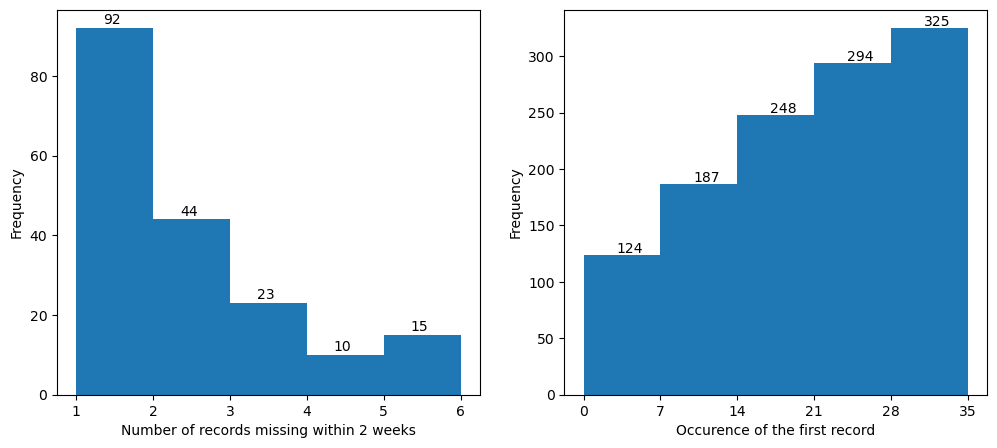

In [675]:
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
chart = traj.num_missing_14days.plot(kind = 'hist', bins = [1, 2, 3, 4, 5, 6], ax = plt.gca())
chart.set_xlabel('Number of records missing within 2 weeks')
for p in plt.gca().patches:
    plt.gca().annotate(round(p.get_height()), (p.get_x()+0.35, p.get_height()+1))
    
plt.subplot(1, 2, 2)
ax = traj.first_missing.plot.hist(bins = [0, 7, 14, 21, 28, 35], cumulative = True)
ax.set_xticks(list(range(0,35+1,7)), list(range(0,35+1,7)))
ax.set_xlabel('Occurence of the first record')
for p in plt.gca().patches:
    plt.gca().annotate(round(p.get_height()), (p.get_x() + 3, p.get_height() + 2))

#### III-2 Extract covid cases 

In [678]:
traj['home_state'] = homeState['home_state']
traj['home_state_county'] = homeState['home_state_county']

`sum(~traj.home_state_county.isin(covid.state_county.unique())) = 0` \
`sum(~traj.home_state.isin(covid_state.state_abbr.unique())) = 0`

In [679]:
print('Can locate covid record for the home county of every panelist.')

Can locate covid record for the home county of every panelist.


In [683]:
def extract_covid(user_record, covid_county_df, covid_state_df):
    """
    This function is used to extract # of covid cases for each day in user's trajectory
    
    """
    index = ['year', 'month', 'day', 'cases', 'cases_avg', 'cases_avg_per_100k', 'deaths', 'deaths_avg', 'deaths_avg_per_100k']
    covid_county = covid_county_df[covid_county_df.state_county == user_record.home_state_county][index]
    covid_state = covid_state_df[covid_state_df.state_abbr == user_record.home_state][index]
    
    
    df = pd.DataFrame(user_record.trajectory[:,:3]).rename(dict(zip(range(3), ['year', 'month', 'day'])), axis = 1)
    
    df_county = df.merge(covid_county, left_on = ['year', 'month', 'day'], right_on = ['year', 'month', 'day'], how = 'left')
    df_county.replace(np.nan, 0, inplace = True)
    df_state = df.merge(covid_state, left_on = ['year', 'month', 'day'], right_on = ['year', 'month', 'day'], how = 'left')
    df_state.replace(np.nan, 0, inplace = True)
    
    return np.array(df_county.iloc[:, 3:]), np.array(df_state.iloc[:, 3:])

In [684]:
rec_covid = traj.progress_apply(lambda x: extract_covid(x, covid_county, covid_state), axis = 1)
traj = traj.join(pd.DataFrame(rec_covid.to_list(), index = x.index, columns = ['covid_county', 'covid_state']))

100%|███████████████████████████████████████████████████████████████████████████████████████| 573/573 [02:24<00:00,  3.95it/s]


In [685]:
traj.head()

,trajectory,days_w_rec,total_span,per_days_w_rec,min_date,max_date,max_consecutive_missing,first_missing,num_missing_7days,num_missing_14days,num_missing_21days,num_missing_28days,home_state,home_state_county,covid_county,covid_state
panelist_id,,,,,,,,,,,,,,,,
EMBUSA-1033561,"[[2020, 1, 5, 1, 6, 0.0, 0.0, 0], [2020, 1, 6,...",939,1000,0.939000,2020-01-05,2022-09-30,2.0,2.0,2,5,7,9,KS,"(KS, Wyandotte)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
EMBUSA-1175033,"[[2020, 2, 25, 9, 1, 0.0, 0.0, 0], [2020, 2, 2...",681,701,0.971469,2020-02-25,2022-01-25,4.0,33.0,0,0,0,0,NV,"(NV, Clark)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
EMBUSA-1182541,"[[2019, 12, 31, 1, 1, 0.0, 0.0, 0], [2020, 1, ...",944,990,0.953535,2019-12-31,2022-09-15,4.0,8.0,0,3,5,5,IL,"(IL, Cook)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
EMBUSA-1222267,"[[2019, 12, 30, 1, 0, 0.0, 0.0, 0], [2019, 12,...",839,911,0.920966,2019-12-30,2022-06-27,4.0,62.0,0,0,0,0,AZ,"(AZ, Pinal)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
EMBUSA-1277336,"[[2019, 12, 30, 1, 0, 0.0, 0.0, 0], [2019, 12,...",835,861,0.969803,2019-12-30,2022-05-08,4.0,6.0,1,1,1,1,OH,"(OH, Cuyahoga)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."


In [899]:
def user_rec_df(panelist_id):
    """
    A function that takes panelist_id and return a dataframe with user's commuting trajectory
    
    Information includes:
    
    year, month, day, week, weekday, commute/commute_filled, missing, covid cases in the home state/county
   
   """
    
    user_rec = traj.loc[panelist_id]
    traj_ = pd.DataFrame(user_rec['trajectory']).rename(dict(zip(range(8), ['year', 'month', 'day', 'week', 'weekday', 'commute', 'commute_filled', 'missing'])), axis = 1)
    covid_county = pd.DataFrame(user_rec['covid_county']).rename(dict(zip(range(6), ['cases_c', 'cases_avg_c', 'cases_avg_per_100k_c', 'deaths_c', 'deaths_avg_c', 'deaths_avg_per_100k_c'])), axis = 1)
    covid_state = pd.DataFrame(user_rec['covid_state']).rename(dict(zip(range(6), ['cases_s', 'cases_avg_s', 'cases_avg_per_100k_s', 'deaths_s', 'deaths_avg_s', 'deaths_avg_per_100k_s'])), axis = 1)
    df = traj_.join(covid_county).join(covid_state)
    df['date'] = df.apply(lambda x: datetime(x.year, x.month, x.day), axis = 1)
    
    year2020 = pd.concat([df[df.year == 2020], df[df.year == 2021][:3]])
    year2021 = pd.concat([df[df.year == 2021][3:], df[df.year == 2022][:2]])
    year2022 = df[df.year == 2022][2:]
    
    return df, year2020, year2021, year2022, user_rec.home_state, user_rec.home_state_county

def commute_summary(panelist_id):
    
    user_rec, year2020, year2021, year2022, state, county = user_rec_df(panelist_id)
    
    plt.figure(figsize = (20, 15))
    
    plt.subplot(4, 3, 1)
    ax = year2020.groupby('week')['commute'].sum().plot()
    ax.set_xlim([1, year2020.week.max()])
    ax.set_xticks(range(1, year2020.week.max()+1, 4), range(1, year2020.week.max()+1, 4))
    ax.set_ylabel('# of days commute')
    ax.set_title('2020')
    
    plt.subplot(4, 3, 2)
    ax = year2021.groupby('week')['commute'].sum().plot()
    ax.set_xlim([1, year2021.week.max()])
    ax.set_xticks(range(1, year2021.week.max()+1, 4), range(1, year2021.week.max()+1, 4))
    ax.set_ylabel('# of days commute')
    ax.set_title('2021')
    
    plt.subplot(4, 3, 3)
    ax = year2022.groupby('week')['commute'].sum().plot()
    ax.set_xlim([1, year2022.week.max()])
    ax.set_xticks(range(1, year2022.week.max()+1, 4), range(1, year2022.week.max()+1, 4))
    ax.set_ylabel('# of days commute')
    ax.set_title('2022')
    
    plt.subplot(4, 3, 4)
    ax = year2020.groupby('week')['commute_filled'].sum().plot()
    ax.set_xlim([1, year2020.week.max()])
    ax.set_xticks(range(1, year2020.week.max()+1, 4), range(1, year2020.week.max()+1, 4))
    ax.set_ylabel('# of days commute (filled)')
    
    plt.subplot(4, 3, 5)
    ax = year2021.groupby('week')['commute_filled'].sum().plot()
    ax.set_xlim([1, year2021.week.max()])
    ax.set_xticks(range(1, year2021.week.max()+1, 4), range(1, year2021.week.max()+1, 4))
    ax.set_ylabel('# of days commute (filled)')
    
    plt.subplot(4, 3, 6)
    ax = year2022.groupby('week')['commute_filled'].sum().plot()
    ax.set_xlim([1, year2022.week.max()])
    ax.set_xticks(range(1, year2022.week.max()+1, 4), range(1, year2022.week.max()+1, 4))
    ax.set_ylabel('# of days commute (filled)')
    
    plt.subplot(4, 3, 7)
    ax = year2020[['cases_avg_s', 'date']].set_index('date').squeeze().plot()
    ax.set_yticklabels(ax.get_yticks().astype(int), rotation = 75)
    ax.set_ylabel('# covid cases in ' +state)
    
    plt.subplot(4, 3, 8)
    ax = year2021[['cases_avg_s', 'date']].set_index('date').squeeze().plot()
    ax.set_yticklabels(ax.get_yticks().astype(int), rotation = 75)
    ax.set_ylabel('# covid cases in ' +state)
    
    plt.subplot(4, 3, 9)
    ax = year2022[['cases_avg_s', 'date']].set_index('date').squeeze().plot()
    ax.set_yticklabels(ax.get_yticks().astype(int), rotation = 75)
    ax.set_ylabel('# covid cases in ' +state)
    
    plt.subplot(4, 3, 10)
    ax = year2020[['cases_avg_c', 'date']].set_index('date').squeeze().plot()
    ax.set_yticklabels(ax.get_yticks().astype(int), rotation = 75)
    ax.set_ylabel('# covid cases in {}, {}'.format(county[1], county[0]))
    
    plt.subplot(4, 3, 11)
    ax = year2021[['cases_avg_c', 'date']].set_index('date').squeeze().plot()
    ax.set_yticklabels(ax.get_yticks().astype(int), rotation = 75)
    ax.set_ylabel('# covid cases in {}, {}'.format(county[1], county[0]))    
    
    plt.subplot(4, 3, 12)
    ax = year2022[['cases_avg_c', 'date']].set_index('date').squeeze().plot()
    ax.set_yticklabels(ax.get_yticks().astype(int), rotation = 75)
    ax.set_ylabel('# covid cases in {}, {}'.format(county[1], county[0]))
    
    plt.show()

In [ ]:
look into average

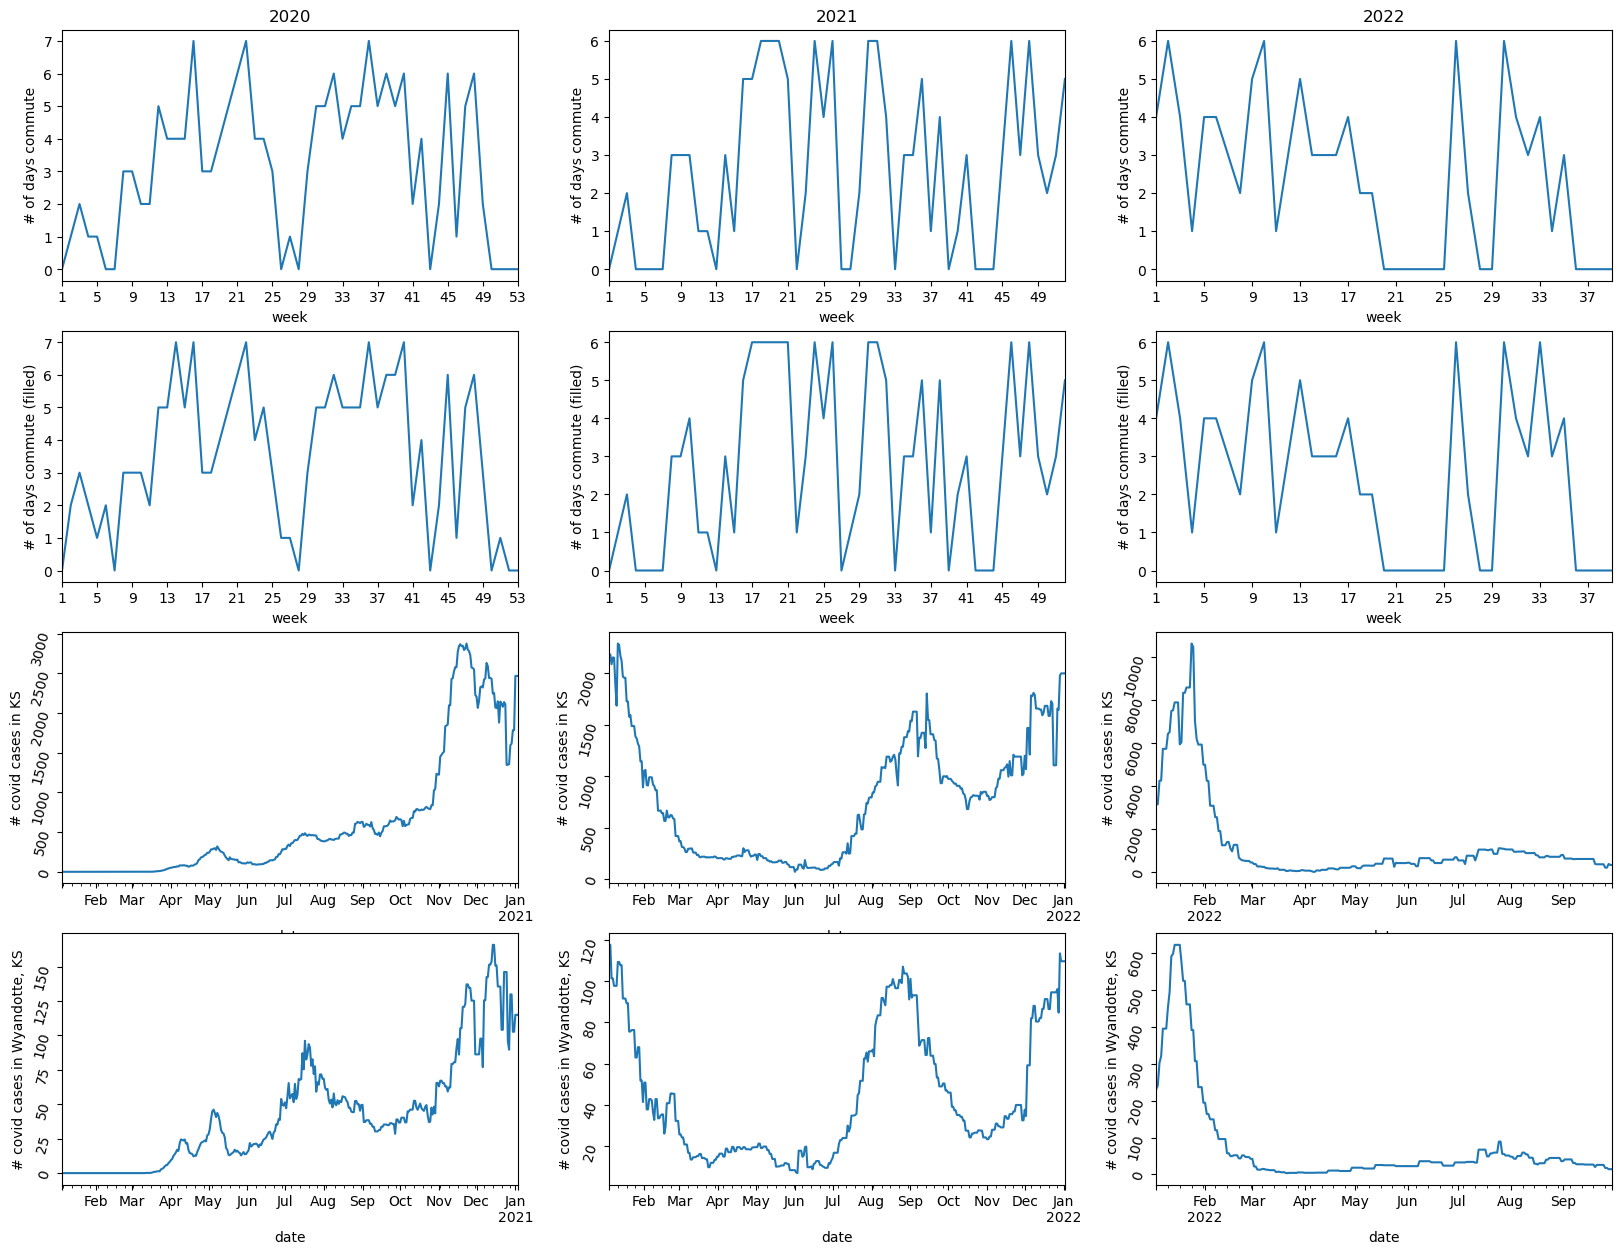

In [900]:
commute_summary('EMBUSA-1033561')

In [974]:
def plot_commute_traj(panelist_id, traj_name):
    
    user_rec, year2020, year2021, year2022, state, county = user_rec_df(panelist_id)
    
    df_list = [year2020, year2021, year2022]
    dict_ = dict(zip(range(7), ['Mon', 'Tu', 'Wed', 'Th', 'Fri', 'Sat', 'Sun']))
    
    plt.figure(figsize = (35, 15))
    
    for i in range(3):
        for j in range(7):
            plt.subplot(3,7,7*i+(j+1))
            ax = df_list[i][[traj_name, 'date']][j::7].set_index('date').squeeze().plot()
            ax.set_yticks([0,1], ['NC', 'C'], fontsize = 15)
            # ax.set_xticklabels(ax.get_xticks(), fontsize = 15)
            # ax.set_xticks(range(df_list[i].week.min(), df_list[i].week.max(), 5), range(df_list[i].week.min(), df_list[i].week.max(), 5), fontsize = 15)
            ax.set_xlabel('')
            if j == 0:               
                ax.set_ylabel('202'+str(i), fontsize = 20)
            if i == 0:
                ax.set_title(dict_[j], fontsize = 15)
    
    plt.show()

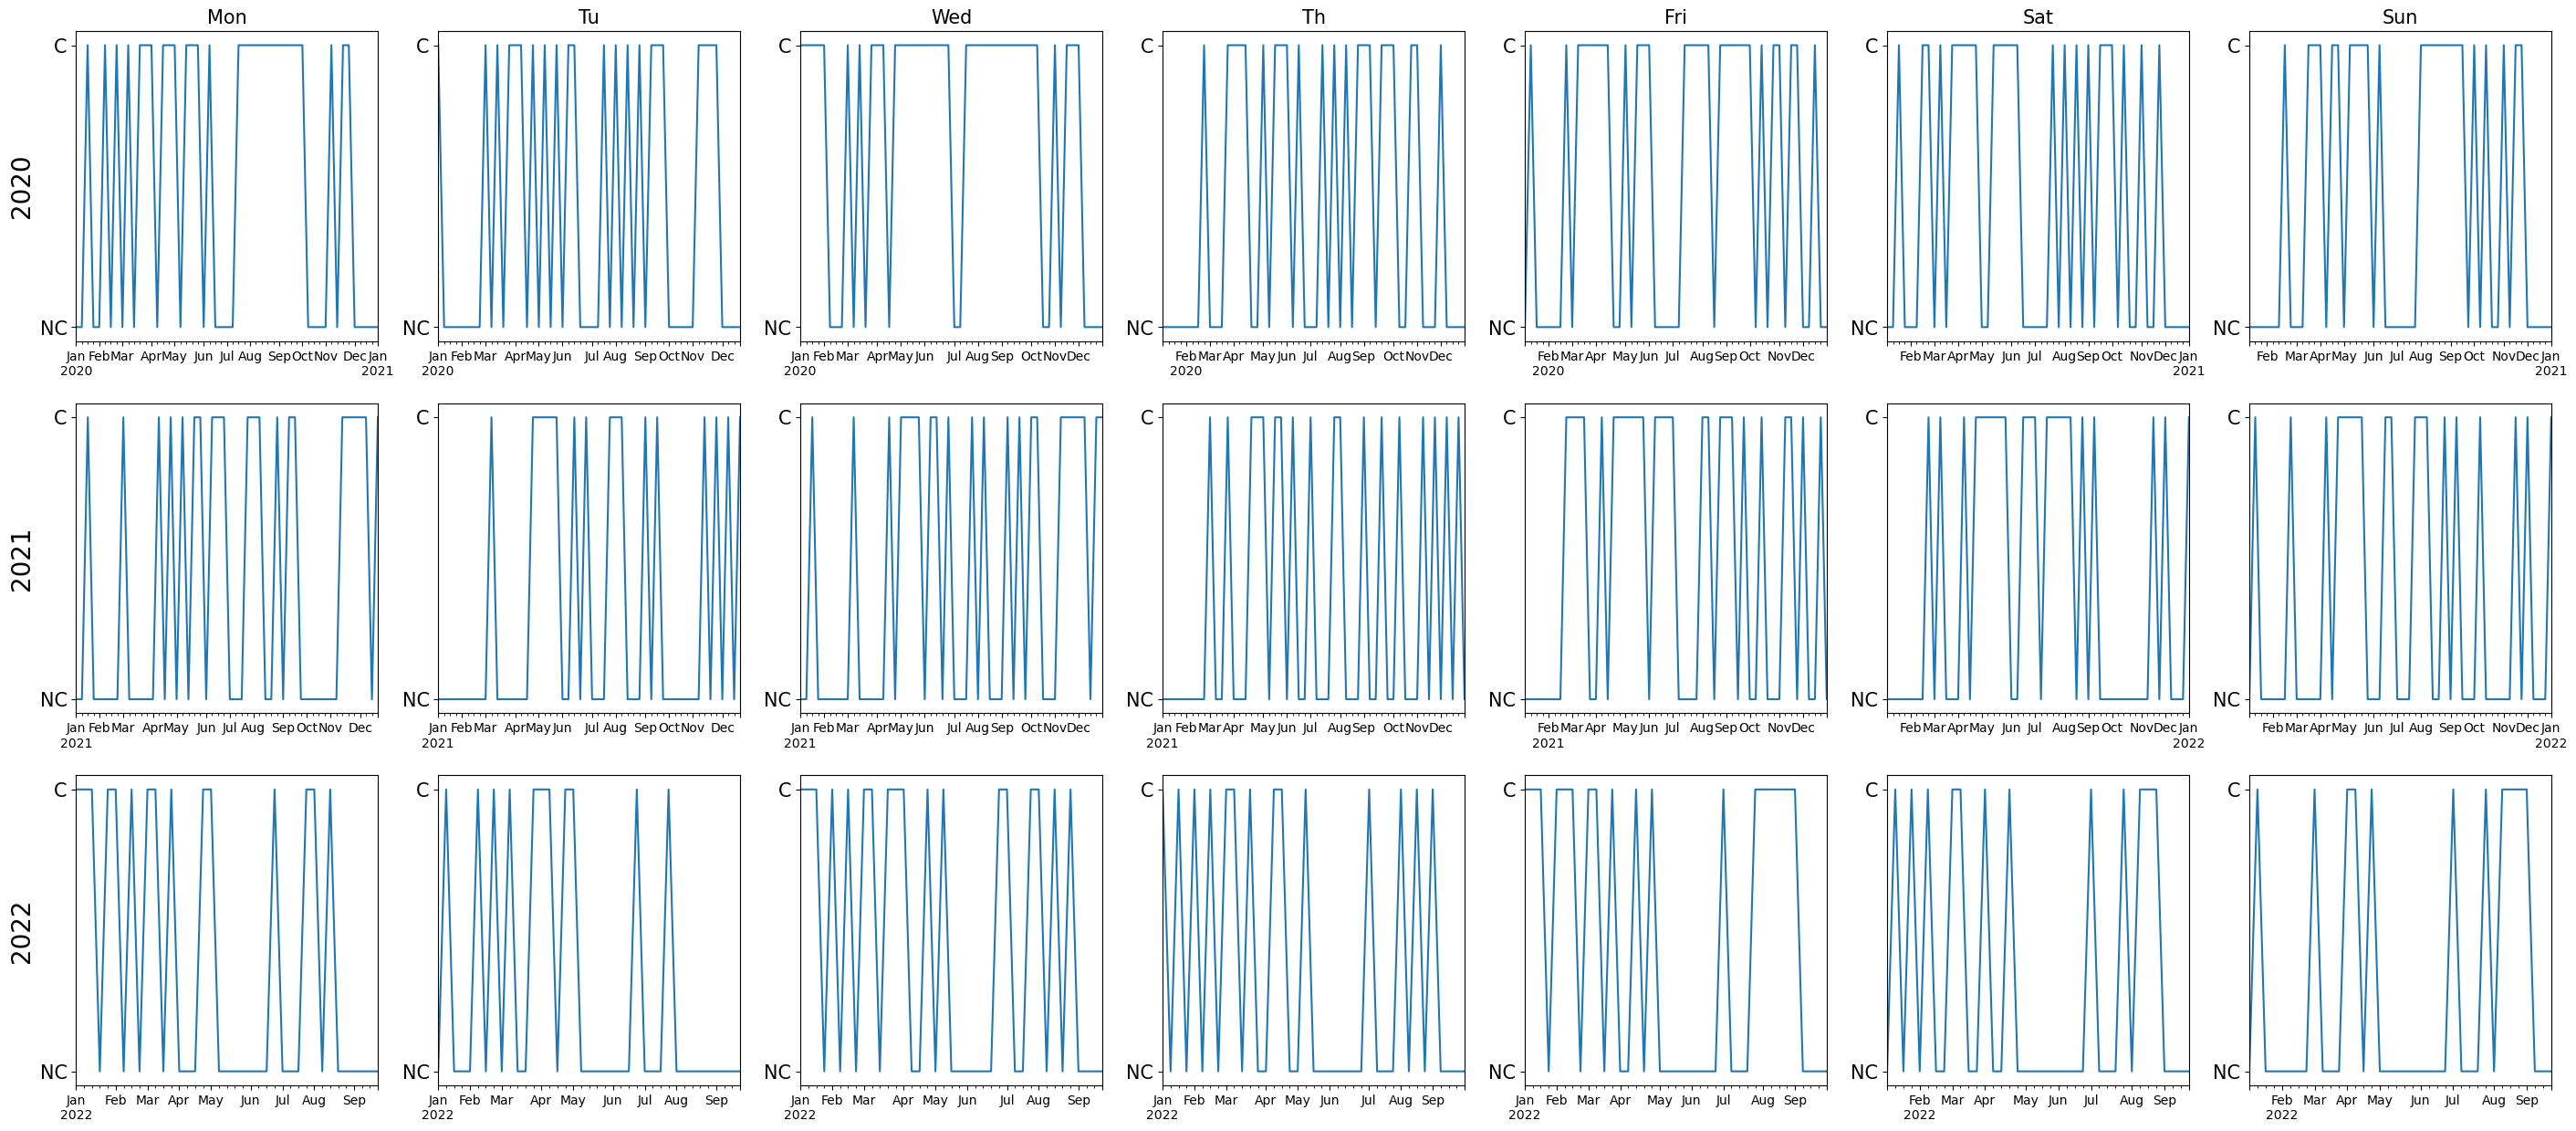

In [975]:
plot_commute_traj('EMBUSA-1033561', 'commute_filled')

In [976]:
for panelist_id in traj.index:
    df, _, _, _, _, _ = user_rec_df(panelist_id)
    df.to_csv('Data/trajectory/traj_{}.csv'.format(panelist_id), index = False)

In [71]:
def split_record(row):
    """
    This function split the records where the user spend overnight in the same place into multirecords
    so that the an activity record spans no more that a day.
    
    
    """
    
    df = pd.DataFrame()
    
    start_datetime = pd.Timestamp(row['arrival_local'].date()) + datetime.timedelta(days = 1)
    end_datetime = row['departure_local'].date() 
    
    row1 = row.copy()
    row1['departure_local'] = start_datetime
    row1['duration'] = (row1['departure_local'] - row1['arrival_local']).total_seconds()
    
    df = pd.DataFrame(row1)
    
    row_res = row.copy()
    row_res['prior_location_name'] = row1['location_name']
    row_res['prior_brand'] = row1['brand']
    row_res['travel_time_s'] = 0
    row_res['distance_traveled_m'] = 0
    row_res['arrival_local'] = pd.date_range(start_datetime, end_datetime, freq = 'd')
    row_res = pd.DataFrame(row_res).T.explode('arrival_local')
    row_res['departure_local'] = row_res['arrival_local'].apply(lambda x: pd.Timestamp(x) + datetime.timedelta(days = 1))
    row_res['duration'] = 86400
    # print(row_res)
    row_res.iloc[-1, -1] = row['departure_local']
    row_res.iloc[-1, -2] = (row_res.iloc[-1]['departure_local'] - row_res.iloc[-1]['arrival_local']).total_seconds()
    
    df = pd.concat([df.T, row_res])
    
    return df
    

In [74]:
record_diffday = records[pd.to_datetime(records.arrival_local).dt.date != pd.to_datetime(records.departure_local).dt.date]

In [75]:
new_records = pd.DataFrame(columns = records.columns)
new_records = new_records.append(record_sameday)

In [102]:
%%time
n = 0
start_time = datetime.datetime.now()
for index, row in record_diffday.iterrows():
    post = split_record(row)
    new_records = new_records.append(post)
    n += 1
    print(n)
    if n % 1000 == 0:
        print('Completed processing {}th record, time elapse {}'.format(index, datetime.datetime.now() - start_time))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [5]:
def split_record(row):

#     if row.arrival_local.date() == row.departure_local.date():  
        
#         return pd.DataFrame(row.copy()).T
    
#     else:
        
    row1 = row.copy()
    row1['departure_local'] = pd.Timestamp(row1['arrival_local'].date()) + datetime.timedelta(days = 1)
    row1['duration'] = (row1['departure_local'] - row1['arrival_local']).total_seconds()
        
    df = pd.DataFrame(row1)
        
    row_res = row.copy()
    row_res['prior_location_name'] = row1['location_name']
    row_res['prior_brand'] = row1['brand']
    row_res['travel_time_s'] = 0
    row_res['distance_traveled_m'] = 0
    row_res['arrival_local'] = row1['departure_local']
        
    while row_res.arrival_local.date() != row_res.departure_local.date():
            
        row2 = row_res.copy()
        row2['departure_local'] = row2['arrival_local'] + datetime.timedelta(days = 1)
        row2['duration'] = 86400
        df = pd.concat([df,row2], axis = 1)
            
        row_res['arrival_local'] = row2['departure_local']
            
    row_res['duration'] = (row_res['departure_local'] - row_res['arrival_local']).total_seconds()
    df = pd.concat([df, row_res], axis = 1)
        
    return df.T

#### Investigate a specific user

In [101]:
columns = ['city', 'state', 'prior_location_name', 'distance_traveled_m', 'travel_time_s', 'longitude', 'latitude', 'location_name', 'is_home', 'is_work', 'arrival_time', 'arrival_date', 'departure_time', 'arrival_weekday']

test = subrecords[(subrecords.third_party_user_id == 1336241)][columns].sort_values(by = ['arrival_time'])
test['arrival_date'].diff().sort_values()

12593003   0 days
2820266    0 days
2820259    0 days
7699870    0 days
6242820    0 days
            ...  
16481118   4 days
4781266    5 days
8685483    5 days
17671212   6 days
14540256      NaT
Name: arrival_date, Length: 3726, dtype: timedelta64[ns]

#### Look into the record that starts 5 days after the previous record

In [102]:
test.loc[8685483]

city                             Pflugerville
state                                      TX
prior_location_name                   unknown
distance_traveled_m                        -1
travel_time_s                              -1
longitude                             -97.604
latitude                               30.454
location_name          Building-1616 FM 685-1
is_home                                 False
is_work                                 False
arrival_time              2022-02-06 09:55:21
arrival_date                       2022-02-06
departure_time            2022-02-06 09:57:19
arrival_weekday                             6
Name: 8685483, dtype: object

In [152]:
test[pd.to_datetime(test.arrival_time).dt.date != pd.to_datetime(test.departure_time).dt.date]

,city,state,prior_location_name,distance_traveled_m,travel_time_s,longitude,latitude,location_name,is_home,is_work,arrival_time,arrival_date,departure_time,arrival_weekday
16473687,Hutto,TX,work,20488.715745,1596,-97.56234,30.52611,home,True,False,2020-04-21 18:09:25,2020-04-21,2020-04-22 06:14:31,1
1927904,Hutto,TX,Mc Donald's,9205.238050,1172,-97.56234,30.52611,home,True,False,2020-04-22 17:41:11,2020-04-22,2020-04-23 06:09:19,2
4781440,Hutto,TX,CVS Pharmacy,6840.824245,457,-97.56234,30.52611,home,True,False,2020-04-24 21:16:12,2020-04-24,2020-04-26 15:44:50,4
16488093,Hutto,TX,work,20493.372671,1549,-97.56234,30.52611,home,True,False,2020-04-26 22:46:06,2020-04-26,2020-04-28 06:08:50,6
1419854,Hutto,TX,work,20488.228088,2336,-97.56234,30.52611,home,True,False,2020-04-28 18:26:07,2020-04-28,2020-04-29 06:14:23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5747023,Hutto,TX,work,20484.897986,2272,-97.56234,30.52611,home,True,False,2022-12-25 18:51:25,2022-12-25,2022-12-26 10:52:12,6
18249408,Hutto,TX,Discount Tire Store,9047.541982,799,-97.56234,30.52611,home,True,False,2022-12-27 18:04:16,2022-12-27,2022-12-28 10:52:28,1
7715673,Hutto,TX,Hutto Veterinary Clinic,1596.421793,319,-97.56234,30.52611,home,True,False,2022-12-28 11:29:17,2022-12-28,2022-12-29 13:50:54,2
15515957,Hutto,TX,work,20485.209897,2045,-97.56234,30.52611,home,True,False,2022-12-29 23:09:10,2022-12-29,2022-12-30 14:41:11,3


#### Look into whether time difference and the travel time matched

In [127]:
tt = (test['arrival_time'] - test['departure_time'].shift(1)).apply(lambda x: x.total_seconds())

In [128]:
tt

14540256        NaN
16487219    82461.0
16473687     1596.0
16940431     2848.0
889259       1787.0
             ...   
13565724     1487.0
13081904     2629.0
15515957     2045.0
12107814      169.0
12600159    21901.0
Length: 3726, dtype: float64

In [129]:
df = pd.DataFrame(tt.iloc[1:] == test['travel_time_s'].iloc[1:])

In [65]:
# Filter records, distance traveled - I should not filter the records by distance and travel time first
records['travel_speed_m/s'] = records['distance_traveled_m']/records['travel_time_s']
mask1 = (records['distance_traveled_m'] > 400) & (records['distance_traveled_m'] < 77248) # commute distance no longer than 48 miles (from Berkeley to San Jose), no shorter than 400 meters
mask2 = (records['travel_time_s'] > 300) & (records['travel_time_s'] < 7200) # commute time no longer than 2 hours, no less than 5 mins
mask3 = (records['travel_speed_m/s'] > 0) & (records['travel_speed_m/s'] < 30) # average speed no greater than 65 mph
records = records[mask1 & mask2 & mask3]